Train a CNN to perform skin lesion classification, based on the ISIC 2017 challenge. There are three classes, 
nervus, melanoma and keratosis. 


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from classifier import ClassifierTrainer
import classifier as cl
from fastai.conv_learner import *

In [13]:
# you will have to change this. I've copied skin_cancer to the cyphy folder of HPC. 
# It's in /work/cyhpy/SeanMcMahon/datasets/skin_cancer
# You will have to mount /work/cyhpy/ on your local machine to access this.
PATH = Path('/home/sean/hpc-home/skin_cancer') 

In [8]:
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification/'
test_csv = PATH / 'ISIC/test_classes_multi_halfn.csv'

train_csv = PATH / 'train_classes_multi_halfn.csv'

# can be resnet101, resnet34, inceptionv4, and many others
# Resnet34 is a good starting point because it trains quicker, 
# once it's working would recommend resnet101 for better performance
arch = resnet34
im_size = 224
bs = 32
# number of threads to use for data loading
num_workers = 4

weight_name = f'example_train_{im_size}_{train_csv.name}'

augs = transforms_top_down + \
    [RandomZoom(zoom_max=1.1, zoom_min=-0.5), RandomBlur()]

assert all([PATH.exists(), train_csv.exists(), test_csv.exists()]), 'Invalid paths'

# The last 150 images of the training csvs are from the ISIC validation set.
# You can also set this to None and fastai will randomly sample images from the trainset.
val_idx = None # get_val_idx(train_csv)

trainer = ClassifierTrainer(PATH, arch, im_size, bs, train_csv, aug_tfms=augs, 
                            test_folder=test_folder, val_idx=val_idx, sn=weight_name, 
                            test_csv=test_csv, num_workers=num_workers)

# Might want to change this with different data, 1e-2 should work well with resnets.
trainer.set_lr(1e-2)

Saving model as "example_train_224_train_classes_multi_halfn.csv"
-> Train set value counts
nevus        4164
melanoma     1221
keratosis     562
Name: classes, dtype: int64
Test set value counts
nevus        393
melanoma     117
keratosis     90
Name: classes, dtype: int64
Dataset has: ['keratosis', 'melanoma', 'nevus'] classes
Cuda: True; Cudnn True


In [9]:
# I big issue I had was a different ordering of images loaded from the csv (for the labels),
# and those from the test_folder (passed through the network)
trainer.check_test_names()

In [10]:
trainer.init_fit()

  1%|          | 1/149 [00:11<28:51, 11.70s/it, loss=1.71]

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                    
    0      0.747734   0.609182   0.739277  
    1      0.68466    0.558462   0.748528                    



epoch      trn_loss   val_loss   accuracy                    
    0      0.607847   0.528126   0.762826  
    1      0.592631   0.518399   0.76619                     

Saved weights as "example_train_224_train_classes_multi_halfn.csv"


In [11]:
results = trainer.test_val(sf=False)

Accuracy = 0.77
Confusion Matrix:
[[ 48   3  62]
 [  2  94 159]
 [ 15  37 769]]
AUC for class 0, id keratosis = 0.92
AUC for class 1, id melanoma = 0.87
AUC for class 2, id nevus = 0.83


Loading ys from csv; shape (600,); vals [0 1 2]; in folder "ISIC/ISIC-2017_Test_v2_Data_Classification/"
Accuracy = 0.68
Confusion Matrix:
[[ 34   3  53]
 [ 11  33  73]
 [ 25  26 342]]
AUC for class 0, id keratosis = 0.85
AUC for class 1, id melanoma = 0.73
AUC for class 2, id nevus = 0.75
----------------------------------------
[[ 34   3  53]
 [ 11  33  73]
 [ 25  26 342]]


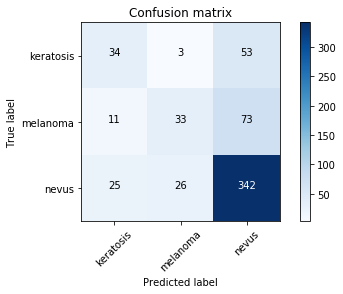

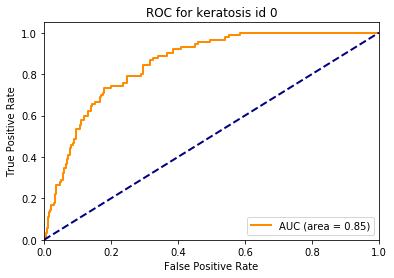

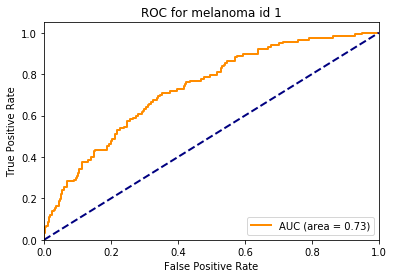

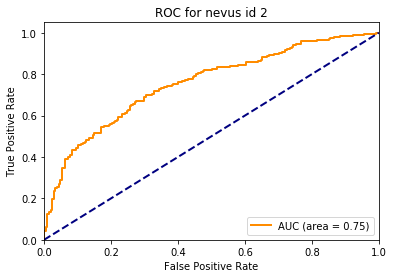

In [12]:
results = trainer.test_eval(sf=True)

In [ ]:
# Can use Test Time Augmentation (TTA), to get better performance
results = trainer.test_eval(tta=True, sf=False)

In [ ]:
trainer.inter_fit()

In [ ]:
# the model usually starts to overfit during this training scheme.
trainer.final_fit()